In [1]:
import mpramnist
from mpramnist.StarrSeq.dataset import StarrSeqDataset

from mpramnist.models import CNN_cls
from mpramnist.trainers import LitModel_StarrSeq

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data

import lightning.pytorch as L
from lightning.pytorch.callbacks import ModelCheckpoint

from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
)
import matplotlib.pyplot as plt

In [2]:
def plot_pr_auc(model, loader, threshold=0.5, figsize=(4, 3)):
    """
    Plot Precision-Recall curve and compute PR-AUC metrics.

    Args:
        model: Trained PyTorch model
        loader: DataLoader with test/validation data
        threshold: Decision threshold for precision/recall calculation
        figsize: Size of the output figure
    """
    sigmoid = nn.Sigmoid()

    # Get predictions
    predictions = trainer.predict(model, dataloaders=loader)

    y_preds = torch.cat([pred["predicted"] for pred in predictions]).cpu()
    targets = torch.cat([pred["target"] for pred in predictions]).cpu()

    y_scores = sigmoid(y_preds).numpy()
    y_true = targets.numpy()

    # Diagnostic info
    print(f"Class distribution: {np.unique(y_true, return_counts=True)}")
    print(f"Score range: [{y_scores.min():.3f}, {y_scores.max():.3f}]")

    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    # Plot with more detail
    plt.figure(figsize=figsize)
    plt.plot(recall, precision, label=f"PR Curve (AP={avg_precision:.2f})", linewidth=2)

    # Add baseline (random classifier)
    positive_ratio = y_true.mean()
    plt.axhline(
        y=positive_ratio,
        color="r",
        linestyle="--",
        label=f"Random (AP={positive_ratio:.2f})",
    )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Tasks

In [3]:
tasks = [
    "RandomEnhancer",  # 0
    "GenomicPromoter",  # 1
    "CapturePromoter",  # 2
    "GenomicEnhancer",  # 3
    "AtacSeq",  # 4
    "Binary",  # 5
]

# Random Enhancer

In [4]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([t.Seq2Tensor()])
val_test_transform = t.Compose([t.Seq2Tensor()])
task = "RandomEnhancer"
train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data"
)

100%|██████████| 506M/506M [01:31<00:00, 5.54MB/s] 


100%|██████████| 126M/126M [00:32<00:00, 3.85MB/s] 


100%|██████████| 211M/211M [01:20<00:00, 2.62MB/s] 


In [15]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [16]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 7942528 (MpraDaraset)
    Number of datapoints: 7942528
    Used split fold: train
Dataset StarrSeqDataset of size 3309387 (MpraDaraset)
    Number of datapoints: 3309387
    Used split fold: test


In [17]:
seq_len = len(train_dataset[0][0][0])
model = CNN_cls(seq_len=seq_len)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-2,
    print_each=1,
)

In [18]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=20,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

   | Name           | Type                   | Params | Mode 
-------------------------------------------------------------------
0  | model          | CNN_cls                | 540 K  | train
1  | loss           | BCEWithLogitsLoss      | 0      | train
2  | train_pearson  | PearsonCorrCoef        | 0      | train
3  | val_pearson    | PearsonCorrCoef        | 0      | train
4  | test_pearson   | PearsonCorrCoef        | 0      | train
5  | val_acc        | BinaryAccuracy         | 0      | train
6  | val_auroc      | 

Sanity Checking: |                                                                             | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Acc: 0.0 | Val AUROC: 0.0 | Val AUPR: 1.0 |
| Val Precision: 0.0 | Val Recall: 0.0 | Val F1: 0.0 
----------------------------------------------------------------------------------------------------



/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)



----------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Acc: 0.5320849418640137 | Val AUROC: 0.5494809150695801 | Val AUPR: 0.5630844235420227 |
| Val Precision: 0.5714786052703857 | Val Recall: 0.25652259588241577 | Val F1: 0.35409894585609436 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 1 | Val Acc: 0.5283763408660889 | Val AUROC: 0.5486012101173401 | Val AUPR: 0.5677536725997925 |
| Val Precision: 0.6078096628189087 | Val Recall: 0.15998013317584991 | Val F1: 0.25329190492630005 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 2 | Val Acc: 0.5251229405403137 | Val AUROC: 0.5453441143035889 | Val AUPR: 0.5648403763771057 |
| Val Precision: 0.6247755289077759 | Val Recall: 0.12579558789730072 | Val F1: 0.20942454040050507 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 3 | Val Acc: 0.5253470540046692 | Val AUROC: 0.5392633080482483 | Val AUPR: 0.5612601041793823 |
| Val Precision: 0.5956255197525024 | Val Recall: 0.1578800529241562 | Val F1: 0.24959971010684967 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 4 | Val Acc: 0.511731743812561 | Val AUROC: 0.5374943017959595 | Val AUPR: 0.5445685386657715 |
| Val Precision: 0.6633017659187317 | Val Recall: 0.04765228554606438 | Val F1: 0.08891670405864716 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 5 | Val Acc: 0.5185215473175049 | Val AUROC: 0.531358003616333 | Val AUPR: 0.5307531356811523 |
| Val Precision: 0.5522999167442322 | Val Recall: 0.19559194147586823 | Val F1: 0.28887975215911865 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 6 | Val Acc: 0.5248500108718872 | Val AUROC: 0.5428226590156555 | Val AUPR: 0.5605683326721191 |
| Val Precision: 0.6137391328811646 | Val Recall: 0.13409118354320526 | Val F1: 0.22009539604187012 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 7 | Val Acc: 0.5194723606109619 | Val AUROC: 0.5426304936408997 | Val AUPR: 0.5543795228004456 |
| Val Precision: 0.5131932497024536 | Val Recall: 0.7574406862258911 | Val F1: 0.6118417382240295 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 8 | Val Acc: 0.5243358016014099 | Val AUROC: 0.5419765710830688 | Val AUPR: 0.5597165822982788 |
| Val Precision: 0.5994918346405029 | Val Recall: 0.14663629233837128 | Val F1: 0.23563583195209503 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.524986982345581 | Val AUROC: 0.5430696606636047 | Val AUPR: 0.563675045967102 |
| Val Precision: 0.6240864992141724 | Val Recall: 0.1256706863641739 | Val F1: 0.2092127501964569 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 10 | Val Acc: 0.528597891330719 | Val AUROC: 0.54517662525177 | Val AUPR: 0.5658086538314819 |
| Val Precision: 0.5760387778282166 | Val Recall: 0.21664616465568542 | Val F1: 0.31487059593200684 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 11 | Val Acc: 0.530440628528595 | Val AUROC: 0.5461578369140625 | Val AUPR: 0.5675066709518433 |
| Val Precision: 0.5689291954040527 | Val Recall: 0.2512517273426056 | Val F1: 0.3485680818557739 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                  | 0/? [00:00<?,…


----------------------------------------------------------------------------------------------------
| Epoch: 12 | Val Acc: 0.5274285078048706 | Val AUROC: 0.5456420183181763 | Val AUPR: 0.5680599212646484 |
| Val Precision: 0.6216316223144531 | Val Recall: 0.14018091559410095 | Val F1: 0.22877253592014313 
----------------------------------------------------------------------------------------------------



In [ ]:
plot_pr_auc(seq_model, test_loader)

# Genomic promoter

In [4]:
BATCH_SIZE = 128
NUM_WORKERS = 103

In [5]:
train_transform = t.Compose(
    [
        t.ReverseComplement(0.5),
        t.Seq2Tensor(),
    ]
)
val_test_transform = t.Compose([t.Seq2Tensor()])

In [6]:
task = "genomicpromoter"
train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data/"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

In [7]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 36898 (MpraDaraset)
    Number of datapoints: 36898
    Used split fold: train
Dataset StarrSeqDataset of size 4098 (MpraDaraset)
    Number of datapoints: 4098
    Used split fold: val
Dataset StarrSeqDataset of size 7285 (MpraDaraset)
    Number of datapoints: 7285
    Used split fold: test


In [8]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [9]:
seq_len = len(train_dataset[0][0][0])

model = CNN_cls(seq_len=seq_len)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=10,
)

In [10]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_aupr", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=30,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.8833577632904053 | Val AUROC: 0.9545644521713257 | Val AUPR: 0.9606752395629883 |
| Val Precision: 0.9202782511711121 | Val Recall: 0.8394338488578796 | Val F1: 0.8779990077018738 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 19 | Val Acc: 0.8887262344360352 | Val AUROC: 0.9556012153625488 | Val AUPR: 0.9611591696739197 |
| Val Precision: 0.8968609571456909 | Val Recall: 0.8784773349761963 | Val F1: 0.8875739574432373 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=30` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 29 | Val Acc: 0.8879941701889038 | Val AUROC: 0.9533363580703735 | Val AUPR: 0.9598255753517151 |
| Val Precision: 0.8963110446929932 | Val Recall: 0.8775012493133545 | Val F1: 0.8868064284324646 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.8889498710632324 | Test AUROC: 0.956946849822998 | Test AUPR: 0.9636529684066772 |
| Test Precision: 0.9455289840698242 | Test Recall: 0.8252267241477966 | Test F1: 0.8812912702560425 
----------------------------------------------------------------------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr           0.9636529684066772
       test_auroc            0.956946849822998
        test_loss            0.265575647354126
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Class distribution: (array([0., 1.], dtype=float32), array([3646, 3639]))
Score range: [0.000, 1.000]


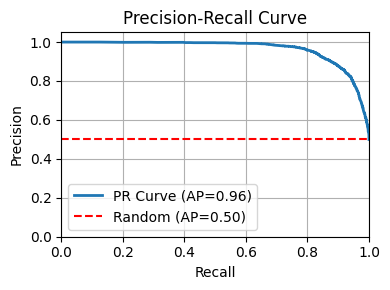

In [12]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_StarrSeq.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-3,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)
plot_pr_auc(seq_model, test_loader)

# Promoter capture

In [2]:
BATCH_SIZE = 512
NUM_WORKERS = 103
train_transform = t.Compose([t.Seq2Tensor()])
val_test_transform = t.Compose([t.Seq2Tensor()])

In [3]:
task = "CapturePromoter"

train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data/"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

In [4]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 79732 (MpraDaraset)
    Number of datapoints: 79732
    Used split fold: train
Dataset StarrSeqDataset of size 13290 (MpraDaraset)
    Number of datapoints: 13290
    Used split fold: val
Dataset StarrSeqDataset of size 13290 (MpraDaraset)
    Number of datapoints: 13290
    Used split fold: test


In [18]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [19]:
seq_len = len(train_dataset[0][0][0])
model = CNN_cls(seq_len=seq_len)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-2,
    print_each=5,
)

In [20]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 386 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
386 K     Trainable params
0         Non-trainable params
386 K     Total params
1.547     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.50
Recall (при пороге 0.5): 1.00
PR-AUC (correct): 0.50
PR-AUC: 0.75


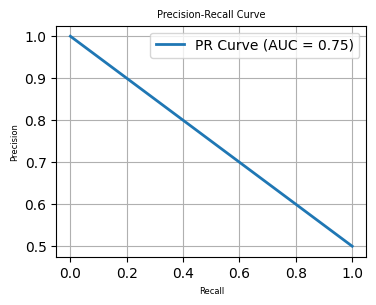

In [21]:
plot_pr_auc(seq_model, test_loader)

# Genome enhancer

In [2]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([t.Seq2Tensor()])
val_test_transform = t.Compose([t.Seq2Tensor()])

In [3]:
task = "GenomicEnhancer"

train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data/"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

In [4]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 323756 (MpraDaraset)
    Number of datapoints: 323756
    Used split fold: ['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Dataset StarrSeqDataset of size 89062 (MpraDaraset)
    Number of datapoints: 89062
    Used split fold: ['chr4', 'chr6', 'chr8']
Dataset StarrSeqDataset of size 99362 (MpraDaraset)
    Number of datapoints: 99362
    Used split fold: ['chr2', 'chr10', 'chr11']


In [24]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [25]:
seq_len = len(train_dataset[0][0][0])
model = CNN_cls(seq_len=seq_len)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-2,
    print_each=5,
)

In [26]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 540 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.162     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.47
Recall (при пороге 0.5): 1.00
PR-AUC (correct): 0.47
PR-AUC: 0.73


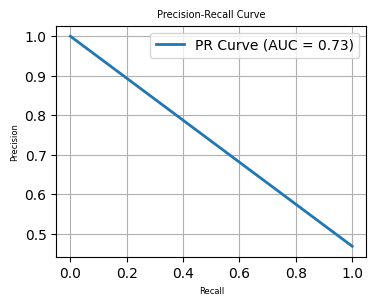

In [27]:
plot_pr_auc(seq_model, test_loader)

# ATACseq

In [2]:
BATCH_SIZE = 2048
NUM_WORKERS = 103
train_transform = t.Compose([t.Seq2Tensor()])
val_test_transform = t.Compose([t.Seq2Tensor()])

In [3]:
task = "atacseq"

train_dataset = StarrSeqDataset(
    task=task, split="train", transform=train_transform, root="../data/"
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

In [4]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 2712578 (MpraDaraset)
    Number of datapoints: 2712578
    Used split fold: ['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Dataset StarrSeqDataset of size 910186 (MpraDaraset)
    Number of datapoints: 910186
    Used split fold: ['chr4', 'chr6', 'chr8']
Dataset StarrSeqDataset of size 912794 (MpraDaraset)
    Number of datapoints: 912794
    Used split fold: ['chr2', 'chr10', 'chr11']


In [30]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [31]:
seq_len = len(train_dataset[0][0][0])
model = CNN_cls(seq_len=seq_len)

seq_model = LitModel_StarrSeq(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-2,
    print_each=5,
)

In [32]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 540 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.162     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.51
Recall (при пороге 0.5): 1.00
PR-AUC (correct): 0.51
PR-AUC: 0.76


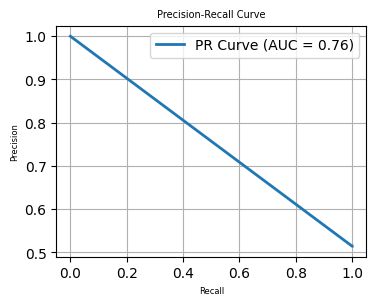

In [33]:
plot_pr_auc(seq_model, test_loader)

# Binary task

In [12]:
class CNN_cls_binary(CNN_cls):
    def __init__(
        self, seq_len, block_sizes=[16, 24, 32, 40, 48], out_ch=64, kernel_size=3
    ):
        super().__init__(
            seq_len=seq_len,
            block_sizes=block_sizes,
            out_ch=out_ch,
            kernel_size=kernel_size,
        )

        self.after_conv = nn.Identity()
        self.head = nn.Identity()

    def forward(self, x):
        out = self.conv_net(x)

        return out

In [13]:
class LitModel_StarrSeq_binary(LitModel_StarrSeq):
    def __init__(
        self,
        weight_decay,
        lr,
        out_ch=64,
        dropout=0.3,
        model=None,
        loss=nn.BCEWithLogitsLoss(),
        print_each=1,
    ):
        super().__init__(
            model=model,
            loss=loss,
            print_each=print_each,
            weight_decay=weight_decay,
            lr=lr,
        )

        final_feature_size = self.model.seq_len

        self.last_block = nn.Sequential(
            nn.Linear(model.block_sizes[-1] * final_feature_size * 2, out_ch),
            nn.BatchNorm1d(out_ch),
            nn.SiLU(),
            nn.Linear(out_ch, out_ch),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(out_ch),
            nn.Linear(out_ch, 1),
        )

    def _process_batch(self, batch):
        seqs, labels = batch
        enhancer = self(seqs["seq_enh"])
        promoter = self(seqs["seq"])
        concat = torch.cat([enhancer, promoter], dim=1)
        out = self.last_block(concat).squeeze()
        return out, labels

    def training_step(self, batch, batch_nb):
        y_hat, y = self._process_batch(batch)

        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self._process_batch(batch)
        loss = self.loss(y_hat, y)

        self.val_acc(y_hat, y)
        self.val_auroc(y_hat, y)
        self.val_aupr(y_hat, y.long())
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        y_hat, y = self._process_batch(batch)

        loss = self.loss(y_hat, y)

        self.test_acc(y_hat, y)
        self.test_auroc(y_hat, y)
        self.test_aupr(y_hat, y.long())
        self.test_precision(y_hat, y)
        self.test_recall(y_hat, y)
        self.test_f1(y_hat, y)

        self.log("test_loss", loss, on_epoch=True, prog_bar=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        y_hat, y = self._process_batch(batch)

        return {
            "predicted": y_hat.squeeze().cpu().detach(),
            "target": y.cpu().detach().float(),
        }

In [14]:
BATCH_SIZE = 1024
NUM_WORKERS = 103

train_transform = t.Compose(
    [
        # t.ReverseComplement(0.5),
        t.Seq2Tensor(),
    ]
)
val_test_transform = t.Compose([t.Seq2Tensor()])

In [15]:
binary_train = ["promoter_from_input", "enhancer_permutated", "enhancer_from_input"]
task = tasks[6]
# use binary_class = None to define StarrSeq_binary_train_promoter.fasta and StarrSeq_binary_train_enhancer.fasta
# or binary_class = "promoter_from_input"/"enhancer_permutated"/"enhancer_from_input" to define needed option
train_dataset = StarrSeqDataset(
    task=task,
    binary_class=None,
    split="train",
    transform=train_transform,
    root="../data/",
)

val_dataset = StarrSeqDataset(
    task=task, split="val", transform=val_test_transform, root="../data/"
)

test_dataset = StarrSeqDataset(
    task=task, split="test", transform=val_test_transform, root="../data/"
)

using train
using val
using test


In [16]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 2991302 (MpraDaraset)
    Number of datapoints: 2991302
    Used split fold: train
Dataset StarrSeqDataset of size 748828 (MpraDaraset)
    Number of datapoints: 748828
    Used split fold: val
Dataset StarrSeqDataset of size 1252044 (MpraDaraset)
    Number of datapoints: 1252044
    Used split fold: test


In [17]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [18]:
len(train_dataset[0][0]["seq_enh"][0])

150

In [21]:
seq_len = len(train_dataset[0][0]["seq_enh"][0])

model = CNN_cls_binary(
    seq_len=seq_len, block_sizes=[16, 32, 64, 96, 128, 64], kernel_size=5
)

seq_model = LitModel_StarrSeq_binary(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-2,
    print_each=1,
)

In [22]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_aupr", mode="max", save_top_k=1, save_last=False
)
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=10,
    gradient_clip_val=1,
    precision="16-mixed",
    enable_progress_bar=True,
    num_sanity_val_steps=0,
    enable_model_summary=False,
    callbacks=[checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
# Train the model
trainer.fit(seq_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)



----------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Acc: 0.7361156344413757 | Val AUROC: 0.8094954490661621 | Val AUPR: 0.8128597736358643 |
| Val Precision: 0.7385790944099426 | Val Recall: 0.7309529185295105 | Val F1: 0.7347462177276611 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 1 | Val Acc: 0.7249101400375366 | Val AUROC: 0.8202651739120483 | Val AUPR: 0.824813961982727 |
| Val Precision: 0.685752272605896 | Val Recall: 0.830313503742218 | Val F1: 0.7511407136917114 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 2 | Val Acc: 0.7500640749931335 | Val AUROC: 0.8239103555679321 | Val AUPR: 0.8305651545524597 |
| Val Precision: 0.758292019367218 | Val Recall: 0.7341365218162537 | Val F1: 0.7460188269615173 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 3 | Val Acc: 0.7464344501495361 | Val AUROC: 0.8232360482215881 | Val AUPR: 0.8282454013824463 |
| Val Precision: 0.8052064776420593 | Val Recall: 0.6501519680023193 | Val F1: 0.7194194197654724 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 4 | Val Acc: 0.7559279203414917 | Val AUROC: 0.8288267850875854 | Val AUPR: 0.8347251415252686 |
| Val Precision: 0.7814796566963196 | Val Recall: 0.710539698600769 | Val F1: 0.744323194026947 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 5 | Val Acc: 0.7544496059417725 | Val AUROC: 0.8327896595001221 | Val AUPR: 0.8393793702125549 |
| Val Precision: 0.8236133456230164 | Val Recall: 0.6475879549980164 | Val F1: 0.7250701785087585 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 6 | Val Acc: 0.7531061768531799 | Val AUROC: 0.8371132016181946 | Val AUPR: 0.8446491956710815 |
| Val Precision: 0.730754554271698 | Val Recall: 0.8015378713607788 | Val F1: 0.7645112872123718 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 7 | Val Acc: 0.7655963897705078 | Val AUROC: 0.8413663506507874 | Val AUPR: 0.8492155075073242 |
| Val Precision: 0.7656049132347107 | Val Recall: 0.7655803561210632 | Val F1: 0.765592634677887 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 8 | Val Acc: 0.7722267508506775 | Val AUROC: 0.8456248044967651 | Val AUPR: 0.8539313077926636 |
| Val Precision: 0.7919823527336121 | Val Recall: 0.7383965253829956 | Val F1: 0.7642512917518616 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.7726060152053833 | Val AUROC: 0.8466441631317139 | Val AUPR: 0.854892373085022 |
| Val Precision: 0.785362184047699 | Val Recall: 0.7502550482749939 | Val F1: 0.7674073576927185 
----------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=10` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.7722564339637756 | Test AUROC: 0.846288800239563 | Test AUPR: 0.8547006845474243 |
| Test Precision: 0.7846890687942505 | Test Recall: 0.7504209280014038 | Test F1: 0.7671725153923035 
----------------------------------------------------------------------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr           0.8547006845474243
       test_auroc            0.846288800239563
        test_loss           0.48506882786750793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Class distribution: (array([0., 1.], dtype=float32), array([626022, 626022]))
Score range: [0.005, 0.994]


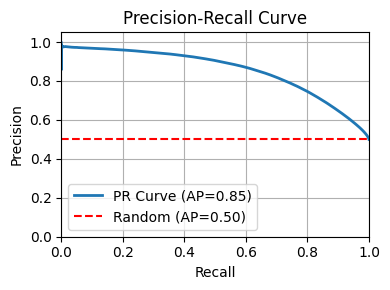

In [24]:
best_model_path = checkpoint_callback.best_model_path
seq_model = LitModel_StarrSeq_binary.load_from_checkpoint(
    best_model_path,
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
    weight_decay=1e-1,
    lr=1e-2,
    print_each=1,
)
trainer.test(seq_model, dataloaders=test_loader)
plot_pr_auc(seq_model, test_loader)